# Loading data

In [ ]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
! unzip ml-1m.zip -d .


In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ratings = (pd.read_csv('./ml-1m/ratings.dat', engine='python', sep='::', names=['user', 'item', 'rating', 'timestamp'])
    .assign(timestamp=lambda df:pd.to_datetime(df.timestamp * 1000000000))
          )

movies = (pd.read_csv('./ml-1m/movies.dat', engine='python', sep='::', names=['item', 'title', 'genres'])
          .assign(genres=lambda df:df.genres.str.split('|').values)
          .set_index('item', drop=False))

# See http://files.grouplens.org/datasets/movielens/ml-1m-README.txt for more details
users = pd.read_csv('./ml-1m/users.dat', engine='python', sep='::', 
                    names=['user', 'gender', 'age', 'occupation', 'zipcode'])\
    .set_index('user', drop=False)

## Train/test split

 * Ideally time based split
 * For the sake of simplicity, let's just sample ratings uniformly (breaking the time machine rule)

In [3]:
test = ratings.sample(n=100000, random_state=0)
train_ratings_mask = ~ratings.index.isin(test.index)
train = ratings.loc[train_ratings_mask]

test_user_items = test[['user', 'item']]

print(train.shape)
print(test.shape)

test.head()

(900209, 4)
(100000, 4)


,user,item,rating,timestamp
324271,1922,2094,4,2000-11-20 04:34:27
818637,4918,2808,1,2000-07-08 19:29:05
148677,957,1660,4,2000-11-25 05:28:13
778790,4653,914,5,2000-11-29 21:22:43
525489,3245,3324,1,2000-09-07 06:33:31


## Biases + KNN

In [5]:
from scipy import sparse
from sklearn.linear_model import LinearRegression

# Re-using UserItemBiasModel from other notebook

def to_coo(row_indexes, col_indexes, values, shape=None, dtype=np.float64):
    return sparse.coo_matrix((values, (row_indexes, col_indexes)), shape=shape, dtype=dtype)

def to_indicator_features(user_items):
    n_samples, _ = user_items.shape
    user_features = to_coo(
        row_indexes=np.arange(n_samples), 
        col_indexes=user_items.user.values, 
        values=np.repeat(1, n_samples))

    item_features = to_coo(
        row_indexes=np.arange(n_samples), 
        col_indexes=user_items.item.values, 
        values=np.repeat(1, n_samples))

    return sparse.hstack([user_features, item_features])


class UserItemBiasModel:
    
    def __init__(self, fitted_model):
        self.fitted_model = fitted_model

    @classmethod
    def train_model(cls, train):
        """ Factory method
        """
        m = LinearRegression(fit_intercept=True)
        indicator_features_matrix = to_indicator_features(user_items=train)
        m.fit(X=indicator_features_matrix, y=train.rating)
        return cls(m)
    
    def predict(self, user_items, output_column='rating'):
        input_features = to_indicator_features(user_items)
        predicted_ratings = self.fitted_model.predict(X=input_features)
        return user_items.assign(**{output_column: lambda _: predicted_ratings})

In [6]:
# Predicting for residuals, that is de-biased ratings 
biases_model = UserItemBiasModel.train_model(train)
debiased_train = (biases_model.predict(train, output_column='predicted')
    .assign(debiased=lambda df: df.rating - df.predicted))

train_matrix = to_coo(
    row_indexes=debiased_train.user,
    col_indexes=debiased_train.item,
    values=debiased_train.debiased
    ).tocsr()

print(train_matrix.__repr__())
debiased_train.head()

<6041x3953 sparse matrix of type '<class 'numpy.float64'>'
	with 900209 stored elements in Compressed Sparse Row format>


,user,item,rating,timestamp,predicted,debiased
0,1,1193,5,2000-12-31 22:12:40,4.655787,0.344213
1,1,661,3,2000-12-31 22:35:09,3.693975,-0.693975
2,1,914,3,2000-12-31 22:32:48,4.398135,-1.398135
3,1,3408,4,2000-12-31 22:04:35,4.080587,-0.080587
4,1,2355,5,2001-01-06 23:38:11,4.056828,0.943172


## Finding similar users/items to extrapolate ratings

Using distances between users according to how they rated items (and vice-versa). https://en.wikipedia.org/wiki/Cosine_similarity is often used.

In [16]:
user1 = train_matrix[1, :].toarray()
user2 = train_matrix[2, :].toarray()

cosine_sim = np.inner(user1, user2) / (np.linalg.norm(user1) * np.linalg.norm(user2))
cosine_sim

array([[ 0.01528445]])

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import normalize

# multiple approaches possible...
user_distances = cosine_similarity(X=train_matrix, dense_output=False)
user_normalized_distances = normalize(user_distances, norm='l1', axis=1)

item_distances = cosine_similarity(X=train_matrix.T, dense_output=False)
item_normalized_distances = normalize(item_distances, norm='l1', axis=0)

# Just keeping the top n items for every item
n_nearest = 50
item_nn = NearestNeighbors(algorithm='brute', n_neighbors=n_nearest, metric='cosine').fit(train_matrix.T)
item_to_nn_items = item_nn.kneighbors_graph()

# Columns sum to 1
normalized_item_to_nn_items = normalize(item_to_nn_items, norm='l1', axis=0)
normalized_item_to_nn_items

<3953x3953 sparse matrix of type '<class 'numpy.float64'>'
	with 197650 stored elements in Compressed Sparse Column format>

In [21]:
# R_hat = R * S
all_predicted_ratings = np.dot(train_matrix, normalized_item_to_nn_items).toarray()

all_predicted_ratings.shape

(6041, 3953)

## Evaluation

In [18]:
def rmse(predicted_ratings, ground_truth_ratings=test):
    # predicted rating will be nan if no prediction => returning nan as a result if not all test ratings provided
    joined_ratings = pd.merge(
        ground_truth_ratings,
        predicted_ratings, 
        on=['user', 'item'], how='left', suffixes=['_ground_truth', '_predicted'])

    squared_errors = np.power(joined_ratings.rating_ground_truth - joined_ratings.rating_predicted, 2)
    
    return np.sqrt(np.average(squared_errors))

In [19]:
bias_predicted_ratings = biases_model.predict(test_user_items)
print(rmse(bias_predicted_ratings))

0.907260048537


In [22]:
predicted_ratings = pd.DataFrame.from_dict(
    {'user': test_user_items.user,
     'item': test_user_items.item,
     'rating': bias_predicted_ratings.rating + all_predicted_ratings[test_user_items.user, test_user_items.item]
    })

print(rmse(predicted_ratings))
predicted_ratings.head()

0.879834784491


,item,rating,user
324271,2094,2.865728,1922
818637,2808,2.193225,4918
148677,1660,4.021869,957
778790,914,3.904955,4653
525489,3324,2.303556,3245


In [24]:
def plot_predicted_distribution(predicted_ratings, ground_truth_ratings=test):
    bins = np.linspace(-.5, 7.5, 9)
    plt.hist(predicted_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, label='predicted')
    plt.hist(ground_truth_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, color='grey', label='ground truth')
    plt.ylabel('rating proportion')
    plt.xlabel('rating value')
    plt.xlim([0, 6]); plt.ylim([0, 1.05])
    plt.xticks(range(1, 6))
    plt.legend(loc=2)

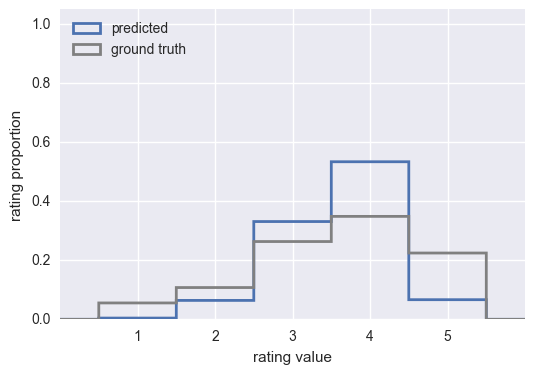

In [25]:
plot_predicted_distribution(predicted_ratings)